# Importing the needed Libraries & Directories

Importing the required libraries and directories are important to avoid errors for it also allows the codes to work perfectly.

In [1]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import tkinter
import matplotlib
matplotlib.use('TkAgg')
import random
import seaborn as sns
import torch
from torch.nn import Sequential
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d
from sklearn.model_selection import train_test_split

directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
incorrect_image = './maskIncorrectDataMaker/mask_incorrect'
no_mask_image = './faceDataMaker/face_resized/'

test_image = './testSetMaker/images/'


df_first = pd.read_csv("./face-mask-detection-dataset/train.csv")
df_incorrect = pd.read_csv("./maskIncorrectDataMaker/train_more_incorrect.csv")
df_no_mask = pd.read_csv("./faceDataMaker/train_face.csv")

df_test = pd.read_csv("./testSetMaker/test.csv")


df_incorrect.drop(columns=df_incorrect.columns[0], axis=1, inplace=True)
df_no_mask.drop(columns=df_no_mask.columns[0], axis=1, inplace=True)





In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


# Importing SSD pretrained weights (Caffe Face Detector Model)

In [3]:
cvNet = cv2.dnn.readNetFromCaffe('./caffe-face-detector-opencv-pretrained-model/architecture.txt','./caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

# Functions to be used

Retrieves Json

In [4]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

Adjusts gamma to make images more bright

In [5]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# Pre-processing the Data

In [6]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '2310.png',
 'NumOfAnno': 3,
 'Annotations': [{'isProtected': False,
   'ID': 81768340414106304,
   'BoundingBox': [213, 169, 325, 299],
   'classname': 'face_other_covering',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 613664631614999424,
   'BoundingBox': [171, 168, 346, 299],
   'classname': 'hijab_niqab',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 166231871773593440,
   'BoundingBox': [435, 183, 470, 223],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [7]:

df_first.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [8]:
df_incorrect.head()


,name,x1,x2,y1,y2,classname
0,61.png,0,0,0,0,face_with_mask_incorrect
1,2880.png,0,0,0,0,face_with_mask_incorrect
2,2676.png,0,0,0,0,face_with_mask_incorrect
3,269.png,0,0,0,0,face_with_mask_incorrect
4,233.png,0,0,0,0,face_with_mask_incorrect


In [9]:
df_no_mask.head()

,name,x1,x2,y1,y2,classname
0,1 (6184).jpg,201,733,201,733,face_no_mask
1,1 (6792).jpg,187,683,187,683,face_no_mask
2,1 (4124).jpg,284,767,284,767,face_no_mask
3,1 (5370).jpg,221,706,221,706,face_no_mask
4,1 (1904).jpg,236,703,236,703,face_no_mask


In [10]:
print(df_first["classname"].unique())

['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


In [11]:
len(df_first)

15409

In [12]:
def output_label(label):
    output_mapping = { 0:"face_with_mask", 1:"face_no_mask" , 2:"face_with_mask_incorrect"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]


num_classes = 3

In [13]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels = { "face_with_mask":0, "face_no_mask":1 , "face_with_mask_incorrect":2 }
MAX_LABEL = 2000

counter = 0

for i in df_first["name"].unique():
    f = i+".json"
    if counter > MAX_LABEL: break
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
            if(j['classname'] in labels):
                x,y,w,h = j["BoundingBox"]
                img = cv2.imread(os.path.join(image_directory,i),1)
                img = adjust_gamma(img,2.0)
                img = img[y:h,x:w]
                img = cv2.resize(img,(img_size,img_size))
                data.append([[img,i],labels[j["classname"]]])
                if labels[j["classname"]] == 0:
                    counter = counter + 1





In [14]:

print(len(data))

2896


#### Add incorrect mask data

In [15]:

counter = 0

for index, row in df_incorrect.iterrows():
    if counter > MAX_LABEL: break
    img = cv2.imread(os.path.join(incorrect_image,row['name']),1)
    img = adjust_gamma(img,2.0)
    try:
        img = cv2.resize(img,(img_size,img_size))
        data.append([[img,row['name']],labels[row['classname']]])
        counter = counter + 1
    except:
        pass

  

In [16]:
print(len(data))

4897


#### Add face_no_mask Data

In [17]:

counter = 0


for index, row in df_no_mask.iterrows():
    if counter > MAX_LABEL - 500: break
    x,y,w,h = row['x1'], row['y1'], row['x2'], row['y2']
    img = cv2.imread(os.path.join(no_mask_image,row['name']),1)
    img = adjust_gamma(img,2.0)
    img = img[y:h,x:w]
    try:
        img = cv2.resize(img,(img_size,img_size))
        data.append([[img,row['name']],labels[row['classname']]])
        counter = counter + 1
    except:
        pass

In [18]:
print(len(data))

6398


#### Shuffle

In [19]:
random.shuffle(data)  

#### Verify balancing

<AxesSubplot:xlabel='count'>

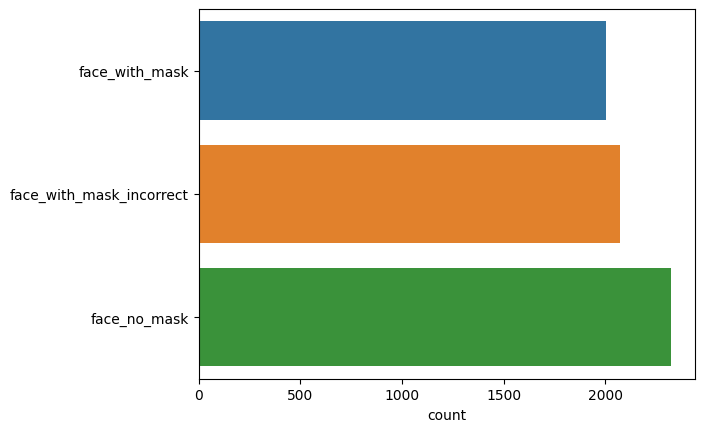

In [20]:

%matplotlib inline

p = []
for face in data:
    p.append(output_label(face[1]))

sns.countplot(y=p)

The lines of code below is used for getting the shape of the features in the face mask data.

In [21]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

print(type(Y[0]))


<class 'int'>


In [22]:
X[0][0].shape

(124, 124, 3)

The lines of code below is used for getting the labels in the face mask data.

In [23]:
# X[0] = np.array(X[0])/255.0
for x in X:
    x[0] = np.array(x[0])/255.0
Y = np.array(Y)

In [24]:
np.unique(Y)

array([0, 1, 2])

In [25]:
Y.shape

(6398,)

0
1
2


/home/saraiva/anaconda3/envs/daa/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  if sys.path[0] == "":


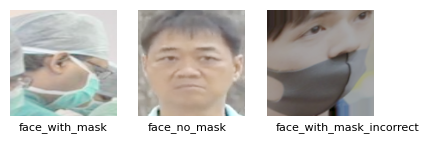

In [26]:
def get_imagem_label(features,labels,label):
    for i in range(len(labels)):
        if output_label(labels[i]) == output_label(label):
            return features[i][0]
    
def visualize_images(features,labels):
    plt.figure(figsize=(8,8))
    for i in range(num_classes):
        print(i)
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(b=None)
        imagem = get_imagem_label(features,labels,i)
        b,g,r = cv2.split(imagem)
        imagem_rgb = cv2.merge((r,g,b))
        
        plt.imshow(imagem_rgb)
        plt.text(10,140,output_label(i),fontsize=8)
    plt.show()


visualize_images(X,Y)

#  Model's Architecture

In [27]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.dropout3 = nn.Dropout(0.25)
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(460800, 50)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = x.float()
        x = nn.ReLU()(self.conv1(x))
        x = self.dropout1(x)
        x = nn.ReLU()(self.conv2(x))
        x = self.dropout2(x)
        x = nn.ReLU()(self.conv3(x))
        x = self.dropout3(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

model = Model()



print(model.conv1.weight.shape)
print(model.conv2.weight.shape)
print(model.conv3.weight.shape)
print(model.fc1.weight.shape)
print(model.fc2.weight.shape)




torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([50, 460800])
torch.Size([3, 50])


The line code below summarizes the model

In [28]:

model.to(device) 

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout3): Dropout(p=0.25, inplace=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=460800, out_features=50, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=3, bias=True)
)

The line code below is for compiling the model by setting the loss to binary cross entropy, the optimizer to adam, and lastly, the metrics to accuracy.

In [29]:
import numpy as np

def get_probs(indexes, outputs):
    res = []
    for j in range(0,32):
        res.append(outputs[j][indexes[j]])
    print(res)
    return torch.tensor(res)

    

In [30]:
from livelossplot import PlotLosses
SAVE_INTERVAL = 2

def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer,epochs):
    liveloss = PlotLosses()
    for epoch in range(epochs):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for batch_i, (inputs, labels) in enumerate(train_dl): 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()     
        liveloss.update(logs)
        liveloss.send()

        if epoch  % SAVE_INTERVAL == 0:
            torch.save(model, h5_file + str(epoch + 1) + '.pth')
            print(f"Saved model checkpoint at epoch {epoch+1}.")

    
    torch.save(model,h5_file)


In [31]:
def make_prediction(model, img): 
    img = img.reshape(1, 3, 124, 124)
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    return prediction
    

### Train Test and Split

In [32]:

from sklearn.model_selection import train_test_split

def removeFileNames(inputSet):

    setData = []
    setFileNames = []

    for value in inputSet:
        setData.append(value[0])
        setFileNames.append(value[1])

    return setData, setFileNames

#Train and test
xtrain, X_test, ytrain, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


xtrain, trainFiles = removeFileNames(xtrain)
X_test, testFiles = removeFileNames(X_test)


#Train to train and val
X_train, X_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.1, random_state=42, stratify=ytrain)


tensor1 = torch.from_numpy(np.array(X_train))
tensor2 =  torch.from_numpy(np.array(X_val))
tensor3 = torch.from_numpy(np.array(X_test))

tensor1 = tensor1.reshape(-1,3,124,124)
tensor2 = tensor2.reshape(-1,3,124,124)
tensor3 = tensor3.reshape(-1,3,124,124)


train = torch.utils.data.TensorDataset( tensor1, torch.tensor(y_train))
val = torch.utils.data.TensorDataset(tensor2, torch.tensor(y_val))
test = torch.utils.data.TensorDataset(tensor3, torch.tensor(y_test))

train_dl = DataLoader(train, batch_size=32)
val_dl = DataLoader(val, batch_size=32)
test_dl = DataLoader(test, batch_size=32)




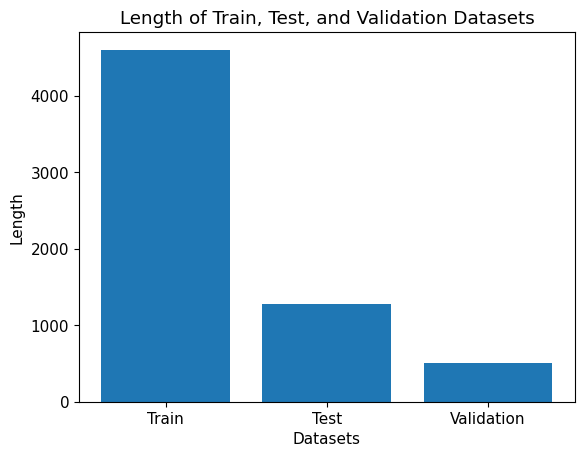

In [48]:
import matplotlib.pyplot as plt

# Data
train_length = len(X_train)
test_length = len(X_test)
validation_length = len(X_val)

# Labels
labels = ['Train', 'Test', 'Validation']

# Heights of the bars
heights = [train_length, test_length, validation_length]

# Bar plot
plt.bar(labels, heights)

# Title and axes labels
plt.title('Length of Train, Test, and Validation Datasets')
plt.xlabel('Datasets')
plt.ylabel('Length')

# Display the plot
plt.show()

In [34]:
import time
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

EPOCHS = 30
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel-final', train_dl, val_dl, model, criterion, optimizer,EPOCHS)
            
            
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

# Evaluate the model

## Read Model

In [35]:
SAVED_MODEL = './CNNModel-final25.pth'
model= torch.load(SAVED_MODEL)


In [36]:
print(len(test_dl))

40


Acc is  0.94453125


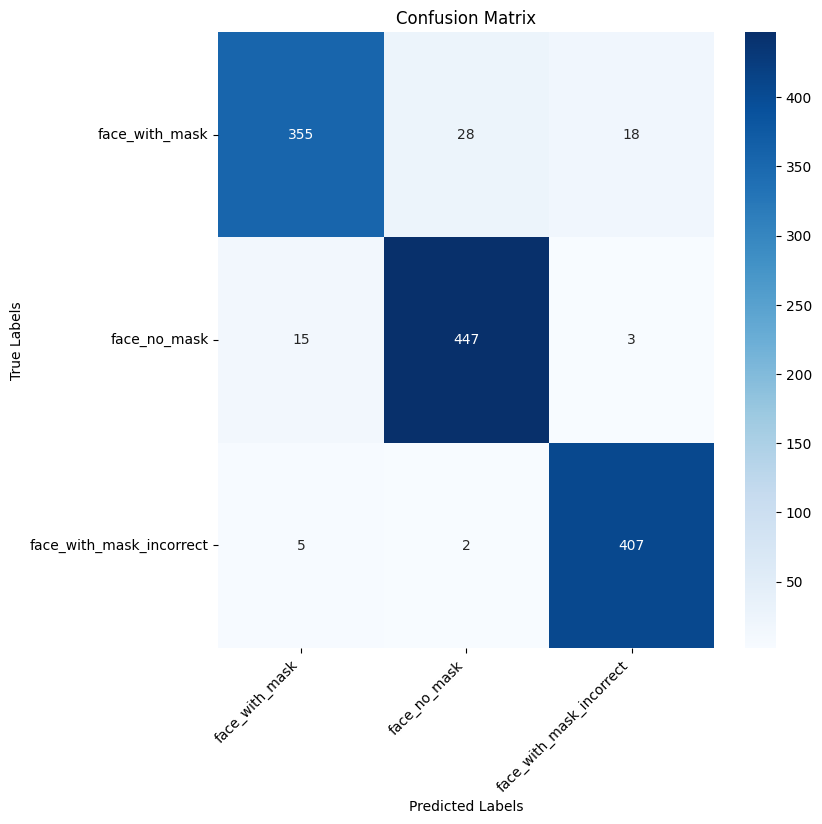

In [37]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

images = []

def evaluate_model(model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl: 
        index = 0
        for i in inputs:
            pred = make_prediction(model,i)
            label = labels.numpy()[index]
            images.append([i,pred])
            index = index + 1
            predictions.append(pred)
            actual_values.append(label)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions


    

actual_values, predictions = evaluate_model(model)

acc = 0

for index,item in enumerate(actual_values):
    if item == predictions[index]:
        acc = acc + 1

print('Acc is ', acc/len(actual_values))

cm = confusion_matrix(actual_values, predictions)

# Creating a figure and axes to plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

# Plotting the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

# Setting axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Setting x and y axis tick labels
ax.xaxis.set_ticklabels(["face_with_mask","face_no_mask","face_with_mask_incorrect"], rotation=45, ha='right')
ax.yaxis.set_ticklabels(["face_with_mask","face_no_mask","face_with_mask_incorrect"], rotation=0)

# Displaying the plot
plt.show()


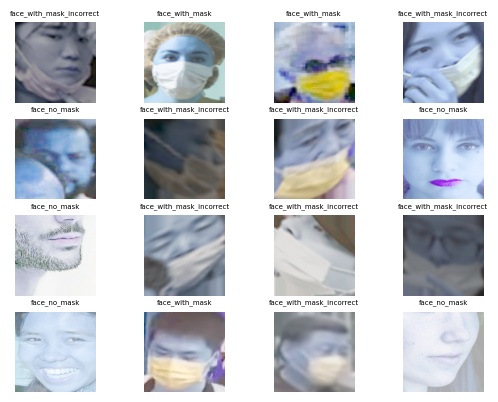

In [38]:

%matplotlib inline

# Selecionar o range de 16 imagens a mostrar com a label que previu
images_to_display = images[16:32]

num_images = 16
image_size = (img_size, img_size)  



num_rows = 4
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols)


for i, ax in enumerate(axes.flat):
    ax.imshow(images_to_display[i][0].reshape(124,124,3))
    ax.axis('off')
    ax.set_title(f"{output_label(images_to_display[i][1])}",fontsize = 5)



plt.show()

In [39]:
import os
import shutil

def copy_files(file_names, source_folders, destination_folder):
    for folder in source_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                if file in file_names:
                    source_path = os.path.join(root, file)
                    index = file_names.index(file)
                    destination_path = os.path.join(destination_folder, f'{output_label(y_test[index])}|{index}')
                    shutil.copy2(source_path, destination_path)
                    print(f"Copied {file} from {source_path} to {destination_path}")


source_folders = [image_directory, incorrect_image, no_mask_image]
destination_folder = test_image

#clean ouput folder
for filename in os.listdir(destination_folder):
    file_path = os.path.join(destination_folder, filename)
    
    if os.path.isfile(file_path):
        os.remove(file_path) 

print("All files in the folder have been removed.")

copy_files(testFiles, source_folders, destination_folder)

Copied 3642.png from ./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/3642.png to ./testSetMaker/images/face_with_mask|35
Copied 4817.png from ./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/4817.png to ./testSetMaker/images/face_with_mask|1040
Copied 2290.png from ./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/2290.png to ./testSetMaker/images/face_with_mask|598
Copied 3953.png from ./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/3953.png to ./testSetMaker/images/face_with_mask|712
Copied 3901.png from ./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/3901.png to ./testSetMaker/images/face_with_mask|473
Copied 2197.png from ./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/2197.png to ./testSetMaker/images/face_with_mask_incorrect|128
Copied 2608.png from ./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/

# SSD vs YOLO

In [40]:
test_images_final = ['2018.jpg','0012.jpg','0020.jpg','0299.jpg']


# SSD

In [41]:
%matplotlib inline

def predSSD(test_images):
    gamma = 2.0
    fig1 = plt.figure(figsize = (14,14))
    rows = 3
    cols = 2
    axes = []
    assign = {0:"mask", 1:"no_mask" , 2:"incorrect"}
    for j,im in enumerate(test_images):
        image =  cv2.imread(os.path.join(image_directory,im),1)
        image =  adjust_gamma(image, gamma=gamma)
        (h, w) = image.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
        cvNet.setInput(blob)
        detections = cvNet.forward()
        for i in range(0, detections.shape[2]):
            try:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                frame = image[startY:endY, startX:endX]
                confidence = detections[0, 0, i, 2]
                if confidence > 0.2:
                    im = cv2.resize(frame,(img_size,img_size))
                    im = np.array(im)/255.0
                    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                   
            
            except Exception as e:
                print(e)
            
        axes.append(fig1.add_subplot(rows, cols, j+1))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

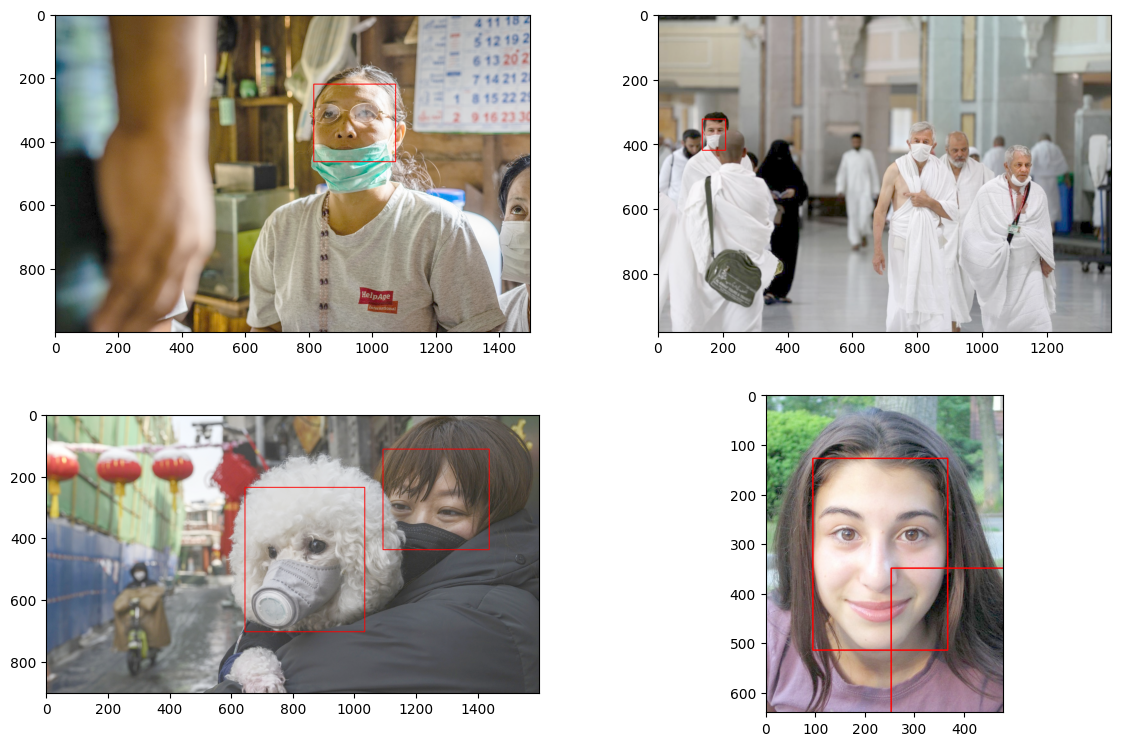

In [42]:
predSSD(test_images_final)

# Yolo

In [43]:
import sys
sys.path.append("/home/saraiva/Desktop/University/SI/AP-Aprendizagem-Profunda/yoloface")

from face_detector import YoloDetector


In [46]:
%matplotlib inline

def predYOLO(test_images,image_directory):

    gamma = 2.0
    fig2 = plt.figure(figsize = (14,14))
    rows = 3
    cols = 2
    axes = []
    assign = {0:"mask", 1:"no_mask" , 2:"incorrect"}

    yolo = YoloDetector(target_size=720, device="cuda:0", min_face=90)
    for j,im in enumerate(test_images):
        image =  cv2.imread(os.path.join(image_directory,im),1)
        image =  adjust_gamma(image, gamma=gamma)
        image = cv2.resize(image, (992,720))
        bboxes,_ = yolo.predict(image)
        for i in range(0, len(bboxes[0])):
            try:
                startX, startY, endX, endY = bboxes[0][i][0], bboxes[0][i][1],bboxes[0][i][2],bboxes[0][i][3]
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                
            
            except Exception as e:
                print(e)
            
        axes.append(fig2.add_subplot(rows, cols, j+1))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

cuda:0
/home/saraiva/Desktop/University/SI/AP-Aprendizagem-Profunda/yoloface/weights/yolov5n_state_dict.pt


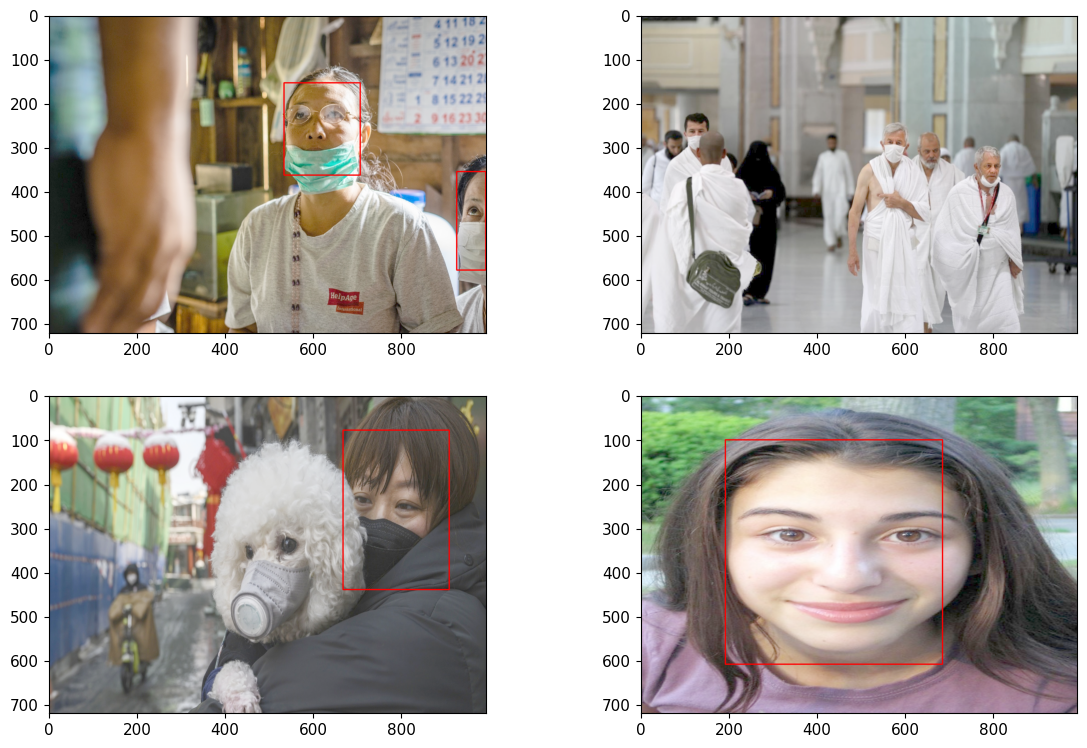

In [47]:
predYOLO(test_images_final,image_directory)